## Part 1. Obtaining the **PubTator** annotations for a set of IDs

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time

import requests
import json

In [3]:
#List of IDs (PMIDS or PMCIDs) expected to be a string for the input. Example: "PMC3486876,PMC3345530,PMC6757961"  (no spaces)

def get_pt_annotations(str_of_ids):

    dfs_list = [] # this is for storing all the Pandas DataFrames
    list_of_ids = str.split(str_of_ids, sep=",")

    for id in list_of_ids:

        if "PMC" in id:
            in_url = "https://www.ncbi.nlm.nih.gov/research/pubtator-api/publications/export/biocjson?pmcids=" + id
        else:
            in_url = "https://www.ncbi.nlm.nih.gov/research/pubtator-api/publications/export/biocjson?pmids=" + id
        

        r = requests.get(in_url)
        try:
            data = r.json()
        except ValueError:
            print(f"Response content is not valid JSON for {id}")
            continue

        if r.status_code == 204:
            print(f"No content - empty response body for {id}")
            continue
        elif r.status_code != 200:
            print(f"Not successful GET request for {id}")
            continue
        
        
        curr_num = list_of_ids.index(id) + 1
        if (curr_num) % 3 == 0:
                time.sleep(0.34)  # abide by the API request limits

        # Putting the annotation text into a list
        annotations = []

        for i in data["passages"]:
            for j in i["annotations"]:
                annotations.append(j["text"])  # appending the annotation values to a list

        annotations

        # Creating a Pandas Series from the data in the annotations list
        pubtator_annotations = pd.Series(annotations, name="text")
        pubtator_annotations    

        # DataFrame representation of the annotation counts
        df = pubtator_annotations.value_counts().to_frame(name="Annotation Counts")

        dfs_list.append(df)
    
    # With a dictionary, we can use the key to easily grab the df associated with a particular PMID or PMCID
    dict_of_dfs = dict(zip(list_of_ids, dfs_list))

    return dict_of_dfs

#### *Example with the get_pt_annotations() function*

In [11]:
#PMC3486876, PMC3345530, PMC6757961
df_pmc = get_pt_annotations("PMC3486876,PMC3345530,PMC6757961")
df_pmc

Response content is not valid JSON for PMC6757961


{'PMC3486876':                     Annotation Counts
 GABA                              106
 mice                               59
 MOX                                54
 Mdr1                               32
 toxicity                           25
 ...                               ...
 1N-methylimidazole                  1
 Mdr1b                               1
 Ala                                 1
 milbemycins                         1
 GABA(A) receptor                    1
 
 [148 rows x 1 columns],
 'PMC3345530':                Annotation Counts
 glycine                       30
 hydrogen                      16
 alpha1 GlyR                   15
 C. elegans                    13
 ECD                           13
 ...                          ...
 milbemycin A4                  1
 MTS                            1
 Pro230                         1
 dips                           1
 leucine 233                    1
 
 [117 rows x 1 columns]}

In [12]:
# Access the DataFrame by the specific name/ID
df_pmc['PMC3486876']

,Annotation Counts
GABA,106
mice,59
MOX,54
Mdr1,32
toxicity,25
...,...
1N-methylimidazole,1
Mdr1b,1
Ala,1
milbemycins,1


In [13]:
my_res = df_pmc['PMC3486876'].reset_index().sort_values(by="Annotation Counts", ascending = False)
my_res = my_res.rename(columns={"index": "Term"})
my_res

,Term,Annotation Counts
0,GABA,106
1,mice,59
2,MOX,54
3,Mdr1,32
4,toxicity,25
...,...,...
86,neurotoxicity of IVM,1
85,overdose,1
84,patients,1
83,Ser,1


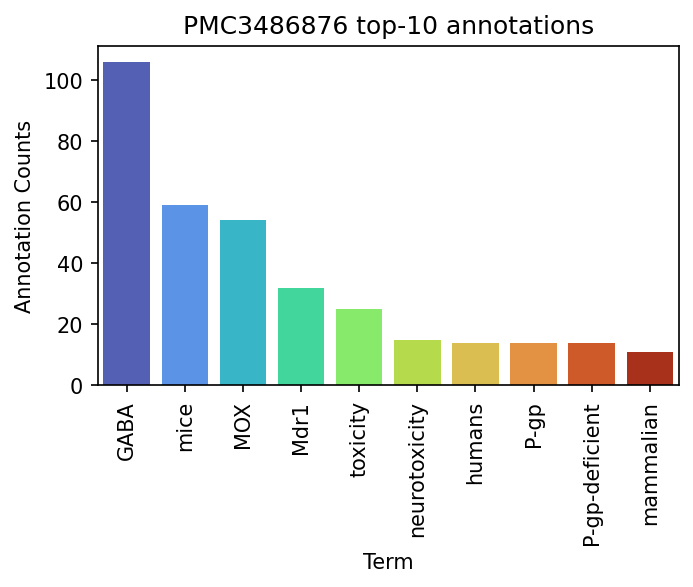

In [42]:
plt.figure(figsize=(5,3),dpi=150)
sns.barplot(data=my_res.head(10), x="Term", y="Annotation Counts", palette="turbo")
plt.xticks(rotation=90);

plt.title("PMC3486876 top-10 annotations")
plt.show()

## Part 2. Information Retrieval with **Biopython** library

To avoid overloading the E-utilities servers, NCBI recommends that users post no more than three URL requests per second and limit large jobs to either weekends or between 9:00 PM and 5:00 AM Eastern time during weekdays.

In [ ]:
from Bio import Entrez
Entrez.email = "Your.Email.Here@example.org" # Always tell NCBI who you are

### Some of the E-utilities: EGQuery, ESearch, ESummary, ELink
- - -

#### *EGQuery example*
##### **EGQuery** will search a query in all Entrez databases and return the number of results for the query in each database.

In [30]:
query = "GABA AND Zebrafish AND GABRA5"

handle = Entrez.egquery(term=query)
record = Entrez.read(handle)

In [31]:
# Results for 'GABA AND Zebrafish AND GABRA5[tiab]'
pd.DataFrame(record["eGQueryResult"])

,DbName,MenuName,Count,Status
0,pubmed,PubMed,0,Term or Database is not found
1,pmc,PubMed Central,45,Ok
2,mesh,MeSH,0,Term or Database is not found
3,books,Books,0,Term or Database is not found
4,pubmedhealth,PubMed Health,Error,Database Error
5,omim,OMIM,0,Term or Database is not found
6,ncbisearch,Site Search,0,Term or Database is not found
7,nuccore,Nucleotide,9,Ok
8,nucgss,GSS,0,Ok
9,nucest,EST,0,Ok


#### *ESearch example*
##### **ESearch** retrieves a set of IDs corresponding to a search query. **ESearch also retrieves the counts for that query.**

- Checking to see if the scientific name (Danio rerio) is translated to Zebrafish with the QueryTranslation from the code.

In [27]:
# Querying against the PubMed database
search_results = Entrez.read(
    Entrez.esearch(db="pubmed", term="GABA AND GABRA1 AND Danio rerio")
)
count = int(search_results["Count"])
print(f"Found {count} results")

Found 8 results


In [28]:
search_results

{'Count': '8', 'RetMax': '8', 'RetStart': '0', 'IdList': ['34925021', '34411917', '33296199', '32753576', '32205311', '30949046', '30324621', '28535436'], 'TranslationSet': [{'From': 'GABA', 'To': '"gamma-aminobutyric acid"[MeSH Terms] OR ("gamma-aminobutyric"[All Fields] AND "acid"[All Fields]) OR "gamma-aminobutyric acid"[All Fields] OR "gaba"[All Fields]'}, {'From': 'Danio rerio', 'To': '"zebrafish"[MeSH Terms] OR "zebrafish"[All Fields] OR ("danio"[All Fields] AND "rerio"[All Fields]) OR "danio rerio"[All Fields]'}], 'TranslationStack': [{'Term': '"gamma-aminobutyric acid"[MeSH Terms]', 'Field': 'MeSH Terms', 'Count': '46542', 'Explode': 'Y'}, {'Term': '"gamma-aminobutyric"[All Fields]', 'Field': 'All Fields', 'Count': '54216', 'Explode': 'N'}, {'Term': '"acid"[All Fields]', 'Field': 'All Fields', 'Count': '2748430', 'Explode': 'N'}, 'AND', 'GROUP', 'OR', {'Term': '"gamma-aminobutyric acid"[All Fields]', 'Field': 'All Fields', 'Count': '53586', 'Explode': 'N'}, 'OR', {'Term': '"gab

##### With the above search results, we see *'From': 'Danio rerio', 'To': '"zebrafish"[MeSH Terms]*
##### - The "zebrafish"[MeSH Terms] includes Danio rerio as an entry term/synonym when retrieving PubMed abstracts.
- If an entry term is used in the query, it is automatically substituted by the related MeSH term.
- "Entry terms are generally used interchangeably with the MeSH preferred term for purposes of cataloging, indexing and retrieval."
    - "*The MeSH preferred term is tagged as [MeSH Terms] in a PubMed or PMC query.*"

In [29]:
idlist = search_results['IdList']
idlist

['34925021', '34411917', '33296199', '32753576', '32205311', '30949046', '30324621', '28535436']

#### *ESummary example*
**ESummary** returns DocSums (document summaries) for a set of provided IDs.

In [24]:
# ESummary
handle = Entrez.esummary(db="pubmed", id="30841457")
record = Entrez.read(handle)

record

[{'Item': [], 'Id': '30841457', 'PubDate': '2019 Mar', 'EPubDate': '2019 Jan 19', 'Source': 'Biomed Pharmacother', 'AuthorList': ['Gupta GL', 'Sharma L'], 'LastAuthor': 'Sharma L', 'Title': 'Bacopa monnieri abrogates alcohol abstinence-induced anxiety-like behavior by regulating biochemical and Gabra1, Gabra4, Gabra5 gene expression of GABA<sub>A</sub> receptor signaling pathway in rats.', 'Volume': '111', 'Issue': '', 'Pages': '1417-1428', 'LangList': ['English'], 'NlmUniqueID': '8213295', 'ISSN': '0753-3322', 'ESSN': '1950-6007', 'PubTypeList': ['Journal Article'], 'RecordStatus': 'PubMed - indexed for MEDLINE', 'PubStatus': 'ppublish+epublish', 'ArticleIds': {'medline': [], 'pubmed': ['30841457'], 'pii': 'S0753-3322(18)38391-4', 'doi': '10.1016/j.biopha.2019.01.048', 'rid': '30841457', 'eid': '30841457'}, 'DOI': '10.1016/j.biopha.2019.01.048', 'History': {'medline': ['2019/06/22 06:00'], 'pubmed': ['2019/03/08 06:00'], 'received': '2018/12/01 00:00', 'revised': '2019/01/14 00:00', '

In [25]:
# Publication date
record[0]["PubDate"]

'2019 Mar'

#### *ELink example*
##### **ELink** checks for linked external articles, and it helps us get the number of articles that have cited "this" publication. 

In [22]:
# ELink
record = Entrez.read(Entrez.elink(dbfrom="pubmed", db="pubmed", id='30841457', linkname="pubmed_pubmed_citedin"))
record

[{'ERROR': [], 'LinkSetDbHistory': [], 'LinkSetDb': [{'Link': [{'Id': '34805114'}, {'Id': '33407346'}, {'Id': '33102860'}], 'DbTo': 'pubmed', 'LinkName': 'pubmed_pubmed_citedin'}], 'DbFrom': 'pubmed', 'IdList': ['30841457']}]

##### **[{'Link': [{'Id': '34805114'}, {'Id': '33407346'}, {'Id': '33102860'}]** 
refers to the 3 articles that cited the publication with PMID 30841457

In [23]:
# Citation counts: 3
len(record[0]["LinkSetDb"][0]["Link"])

3